# GT2021-60283 Demo III - Train a BNN


In [2]:
import pandas as pd
import numpy as np
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from tensorflow import keras
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler

In [13]:
def load_dataset(data_dir, file_stem, label_key, train_df=None, val_df=None,
                 keep_cols=None):
    scaler = StandardScaler()
    if train_df is None or val_df is None:
        train_df = pd.read_csv('{}/{}_train.csv'.format(data_dir, file_stem)).set_index('orig_idx', drop=False)
        val_df = pd.read_csv('{}/{}_val.csv'.format(data_dir, file_stem)).set_index('orig_idx', drop=False)
        test_df = pd.read_csv('{}/{}_test.csv'.format(data_dir, file_stem)).set_index('orig_idx', drop=False)
    if not isinstance(label_key, list):
        label_key = [label_key]
    val = list(train_df.drop(columns=label_key+['orig_idx']).keys())
    if keep_cols is not None:
        val = keep_cols
    for lab_key in label_key:
        assert(lab_key not in val)
    assert('orig_idx' not in val)
    y_train = train_df[label_key].values
    y_val = val_df[label_key].values
    y_test = test_df[label_key].values
    x_dim = len(val)
    X_train = scaler.fit_transform(train_df.loc[:, val])
    X_val = scaler.transform(val_df.loc[:, val])
    X_test = scaler.transform(test_df.loc[:, val])

    return X_train, y_train, X_val, y_val, X_test, y_test, train_df, val_df, test_df, val


def build_model(num_hidden, num_neurons, W1_var, lr,n_train, x_dim, activ_func='relu',
                num_label_categories=None,
                sigmoid_out=False,
                optimiser='adam'):

    # Set params
    FXtractor_hidden=[num_neurons for i in range(num_hidden)]


    data_noise = 0.5
    reg_dicts = []
    shape_in = x_dim
    for i in range(num_hidden):
        if i ==0:
            reg_dict = {'W_var': W1_var/shape_in}
        else:
            reg_dict = {'W_var': 1/num_neurons}
        reg_dict['W_lambda'] = data_noise/reg_dict['W_var']
        reg_dict['W_anc'] = np.random.normal(loc=0,scale=np.sqrt(reg_dict['W_var']),size=[shape_in, num_neurons])
        reg_dict['W_init'] = np.random.normal(loc=0,scale=np.sqrt(reg_dict['W_var']),size=[shape_in, num_neurons])
        if i ==0:
            reg_dict['b_var'] = reg_dict['W_var']*shape_in
        else:
            reg_dict['b_var'] = reg_dict['W_var']
        reg_dict['b_lambda'] = data_noise/reg_dict['b_var']
        reg_dict['b_anc'] = np.random.normal(loc=0,scale=np.sqrt(reg_dict['b_var']),size=[num_neurons])
        reg_dict['b_init'] = np.random.normal(loc=0,scale=np.sqrt(reg_dict['b_var']),size=[num_neurons])
        if i ==num_hidden -2:
            shape_in = num_neurons
            num_neurons = 1
        else:
            shape_in = num_neurons
        reg_dicts.append(reg_dict)
    #print(reg_dicts)
    def build_reg_func(W_anc, W_lambda, n_train):
        def custom_anc_reg(weight_matrix):
            return K.sum(K.square(weight_matrix - W_anc)) * W_lambda/n_train
        return custom_anc_reg

    # Input data
    X = tf.keras.Input(shape=(x_dim,), name='X')

    # Feature extractor
    FXtractor_layers = []
    FXtractor_in = X
    for i, nuerons in enumerate(FXtractor_hidden[:-1]):
        reg_dict = reg_dicts[i]

        FXtractor_layers.append(layers.Dense(nuerons, activation = activ_func,
                                             kernel_initializer=keras.initializers.Constant(value=reg_dict['W_init']),
                                             bias_initializer=keras.initializers.Constant(value=reg_dict['b_init']),
                                             kernel_regularizer=build_reg_func(reg_dict['W_anc'], reg_dict['W_lambda'] ,n_train) ,
                                             bias_regularizer=build_reg_func(reg_dict['b_anc'], reg_dict['b_lambda'] ,n_train)
                                            )(FXtractor_in))
        FXtractor_in = FXtractor_layers[-1]



    if num_label_categories is not None:
        label_activ = 'softmax'
        label_loss = 'sparse_categorical_crossentropy'
        n_label_neurons = num_label_categories
    else:
        label_activ = 'sigmoid'
        label_loss = 'binary_crossentropy'
        n_label_neurons = 1
    reg_dict = reg_dicts[-1]
    # Label predictor - single layer
    label_pred = layers.Dense(n_label_neurons, activation = label_activ,
                                             kernel_initializer=keras.initializers.Constant(value=reg_dict['W_init']),
                                             bias_initializer=keras.initializers.Constant(value=reg_dict['b_init']),
                                             kernel_regularizer=build_reg_func(reg_dict['W_anc'], reg_dict['W_lambda'] ,n_train) ,
                                             bias_regularizer=build_reg_func(reg_dict['b_anc'], reg_dict['b_lambda'] ,n_train)
                                            )(FXtractor_in)

    label_model = Model(inputs=X, outputs=label_pred)

    # Optimization
    if optimiser == 'adam':
        optimiser = tf.keras.optimizers.Adam(learning_rate=lr)
    else:
        optimiser = tf.keras.optimizers.Adadelta()
    label_model.compile(optimizer=optimiser,
                       loss=label_loss,
                       metrics=['accuracy', 'binary_crossentropy'])


    return label_model

def predict_ensemble(NNs, X):
    preds = np.zeros((X.shape[0], len(NNs)))
    for m, NN in enumerate(NNs):
        preds[:, m] = NN.predict(X).reshape(-1)
    return preds, np.mean(preds, axis=1), np.std(preds, axis=1)


In [3]:
dataset_name = 'NTNU0000_OP_T'
X_train, y_train, X_val, y_val, X_test, y_test, train_df, val_df, test_df, pred_cols = load_dataset('data', '{}'.format(dataset_name), 'upper_mic_theta_000_250_label_fut')


In [32]:
indep_div = 3000
n_train = X_train.shape[0]//indep_div
x_dim = X_train.shape[-1]
ensemble_size = 12
num_hidden = 3
num_neurons = 50
lr = 1e-4

In [33]:
NNs = []
for m in range(ensemble_size):
    NNs.append(build_model(num_hidden, num_neurons, 1,  lr,n_train, x_dim,))

In [34]:
preds, pred_mu, pred_std = predict_ensemble(NNs, X_train)

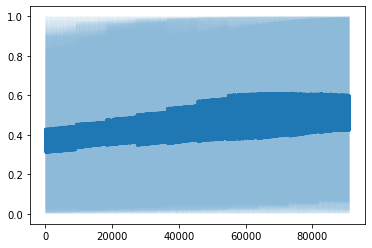

In [35]:
plt.figure()
plt.plot(pred_mu)
plt.fill_between(np.arange(preds.shape[0]), np.percentile(preds, 95, axis=1), np.percentile(preds, 5, axis=1), alpha=0.5)
plt.show()

In [ ]:
train_hists = []
for NN in NNs:
    earlystopping_callback = tf.keras.callbacks.EarlyStopping('val_loss', patience=25)
    train_hists.append(NN.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=2048, epochs=5000,
                 callbacks=[earlystopping_callback], verbose=1))

In [ ]:
preds, pred_mu, pred_std = predict_ensemble(NNs, X_test)
plt.figure()
plt.plot(pred_mu)
plt.fill_between(np.arange(preds.shape[0]), np.percentile(preds, 95, axis=1), np.percentile(preds, 5, axis=1), alpha=0.5)
plt.show()